In [1]:
import jax
import jax.numpy as jnp
from jax import config
from discoeb.background import evolve_background
from discoeb.perturbations import evolve_perturbations, get_power
import matplotlib.pyplot as plt
# plt.style.use('~/.mplstyles/mystyle.mplstyle')

config.update("jax_enable_x64", True)
dtype = jnp.float64

In [2]:
!pip show jax jaxlib numpy diffrax 

Name: jax
Version: 0.5.0
Summary: Differentiate, compile, and transform Numpy code.
Home-page: https://github.com/jax-ml/jax
Author: JAX team
Author-email: jax-dev@google.com
License: Apache-2.0
Location: /gpfs/home5/osavchenko/.local/lib/python3.10/site-packages
Requires: jaxlib, ml_dtypes, numpy, opt_einsum, scipy
Required-by: chex, cosmopower_jax, diffrax, discoeb, equinox, flax, jax-cosmo, jax-tqdm, jax_autovmap, jaxopt, lfx, lineax, optax, optimistix, orbax-checkpoint, pmwd
---
Name: jaxlib
Version: 0.5.0
Summary: XLA library for JAX
Home-page: https://github.com/jax-ml/jax
Author: JAX team
Author-email: jax-dev@google.com
License: Apache-2.0
Location: /gpfs/home5/osavchenko/.local/lib/python3.10/site-packages
Requires: ml-dtypes, numpy, scipy
Required-by: chex, cosmopower_jax, jax, jax-cosmo, jaxopt, lfx, optax
---
Name: numpy
Version: 1.26.4
Summary: Fundamental package for array computing in Python
Home-page: https://numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
Li

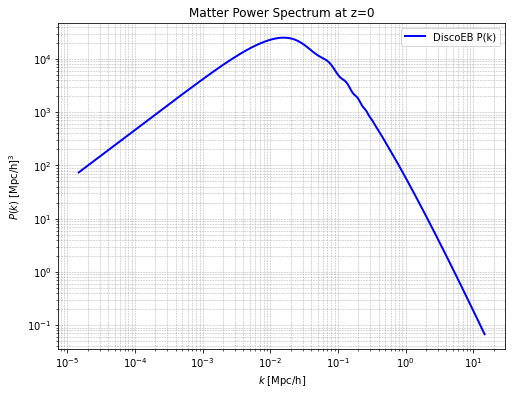

In [3]:
# Compute background evolution
param = {}
param['Omegam'] = 0.3
param['Omegab'] = 0.05
param['w_DE_0'] = -0.99
param['w_DE_a'] = 0.0
param['cs2_DE'] = 0.99  # sound speed of DE
param['Omegak'] = 0.0  # NOTE: Omegak is ignored at the moment!
param['A_s'] = 2.1e-9
param['n_s'] = 0.96
param['H0'] = 67.74  # Hubble constant in km/s/Mpc
param['Tcmb'] = 2.72548  # CMB temperature in K
param['YHe'] = 0.248
Neff = 3.046  # -1 if massive neutrino present
N_nu_mass = 1.0
Tnu = (4.0 / 11.0) ** (1.0 / 3.0)
N_nu_rel = Neff - N_nu_mass * (Tnu / ((4.0 / 11.0) ** (1.0 / 3.0))) ** 4
param['Neff'] = N_nu_rel
param['Nmnu'] = N_nu_mass
param['mnu'] = 0.06  # eV
param['k_p'] = 0.05  # pivot scale for the primordial power spectrum in Mpc^-1
param_bg = evolve_background(param=param, thermo_module='RECFAST')

# Compute perturbations
y, kmodes = evolve_perturbations(param=param_bg, kmin=1e-5, kmax=1e1, num_k=256,
                      aexp_out=jnp.array([1.0]), lmaxg=11, lmaxgp=11, lmaxr=11, lmaxnu=11,
                      nqmax=3, max_steps=2048, rtol=1e-4, atol=1e-4)

# Get the power spectrum at z=0
Pk = get_power(k=kmodes, y=y[:, 0, :], idx=4, param=param_bg)

# Convert to /h units
h = param['H0'] / 100.0
Pk_in_Mpc_h = Pk * h ** 3
kmodes_in_Mpc_h = kmodes / h

# # Also get the Eisenstein & Hu power spectrum for comparison (from DiscoDJ)
# from discodj import DiscoDJ
# dim = 3
# res = 512
# boxsize = 500.0
# cosmo = {"Omega_c": param['Omegam'] - param['Omegab'],
#          "Omega_b": param['Omegab'],
#          "Omega_k": 0.0,
#          "h": h,
#          "n_s": param['n_s'],
#          "sigma8": 0.8,  # This is a placeholder (would need to be computed based on A_s)
#          "w0": -1.0,
#          "wa": 0.0}

# # Define DISCO-DJ object
# dj = DiscoDJ(dim=dim, res=res, device="gpu", precision="double", cosmo=cosmo, boxsize=boxsize)
# dj = dj.with_timetables()
# dj = dj.with_linear_ps(transfer_function="Eisenstein-Hu")

# Plot the power spectrum
plt.figure(figsize=(8, 6))
plt.loglog(kmodes_in_Mpc_h, Pk_in_Mpc_h, label='DiscoEB P(k)', color='blue', linewidth=2)
# plt.loglog(dj.k[:, 0, 0], dj.evaluate_linear_ps(a=1.0, k=dj.k[:, 0, 0]), label='Eisenstein \& Hu P(k)', color='orange', linestyle='--', linewidth=2)
plt.xlabel(r'$k$ [Mpc/h]')
plt.ylabel(r'$P(k)$ [Mpc/h]$^3$')
plt.title('Matter Power Spectrum at z=0')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()